In [13]:
import numpy as np
from numba import jit, njit, prange
import os
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap
import matplotlib.animation as animation
from tqdm.notebook import tqdm

In [14]:
np.random.seed(42)

NAME = 'assignment4'
DATA_PATH = f'data/{NAME}'
MEDIA_PATH = f'media/{NAME}'
[os.makedirs(path, exist_ok=True) for path in [DATA_PATH, MEDIA_PATH]]
print('Setup complete')

Setup complete


# Cellular Pots model

## Helper methods

In [15]:
@njit
def kronecker_delta(i, j):
    """Helper method for calculating Kronecker's delta.

    Args:
        i, j (int): compared values

    Returns:
        int: 1 if i equals j, 0 otherwise
    """    
    return int(i == j)

@njit
def celltype_from_id(sigma, n_types):
    """Helper method for obtaining cell type (tau) based on its ID (sigma).

    Args:
        sigma (int): cell ID
        n_types (int): number of different cell types in the simulation

    Returns:
        int: Cell type for the given cell ID.
    """    
    return (np.mod(sigma, n_types) + 1) * np.minimum(sigma + 1, 1)

## Numba-enhanced code for one Monte Carlo step

In [16]:
@jit()
def change_in_Hvol(sigma, sigma_prime, tau, tau_prime, current_areas, target_areas, lam_vol):
    """Calculates the change in volumetric Hamiltonian, if the current cell is joined into randomly chosen neighbour cell.

    Args:
        sigma (int): ID of the randomly chosen cell
        sigma_prime (int): ID of the randomly chosen neighbour
        tau (int): type of the randomly chosen cell
        tau_prime (int): type of the randomly chosen neighbour
        current_areas (np.ndarray[int]): cell areas in the current simulation state
        target_areas (np.ndarray[int]): 
        lam_vol (float): Lagrange multiplier

    Returns:
        float: numerical change in volumetric Hamiltonian (Hvol)
    """
    a_sigma = current_areas[sigma]
    a_sigma_prime = current_areas[sigma_prime]

    A_sigma = target_areas[tau]
    A_sigma_prime = target_areas[tau_prime]

    delta_Hvol = -1
    if sigma == sigma_prime:
        delta_Hvol = 0
    elif (sigma != 0 and sigma_prime != 0):
        delta_Hvol = lam_vol * (((a_sigma - 1 - A_sigma)**2 + (a_sigma_prime + 1 - A_sigma_prime)**2) -
                                ((a_sigma - A_sigma)**2 + (a_sigma_prime - A_sigma_prime)**2))
    elif (sigma == 0):
        delta_Hvol = lam_vol * ((a_sigma_prime + 1 - A_sigma_prime)**2 -
                                (a_sigma_prime - A_sigma_prime)**2)
    elif (sigma_prime == 0):
        delta_Hvol = lam_vol * ((a_sigma - 1 - A_sigma)**2 -
                                (a_sigma - A_sigma)**2)
        
    return delta_Hvol

@jit()
def change_in_Hbond(grid, i, j, iprime, jprime, J, n_types):
    """Calculates the change in bond Hamiltonian, if the current cell is joined into randomly chosen neighbour cell.

    Args:
        grid (np.ndarray[int, int]): grid with cell IDs
        i (int): y coordinate of randomly chosen cell
        j (int): x coordinate of randomly chosen cell
        iprime (int): y coordinate of randomly chosen neighbour
        jprime (int): x coordinate of randomly chosen neighbour
        J (np.ndarray[int, int]): matrix with surface energies
        n_types (int): number of cell types in the simulation

    Returns:
        float: numerical change in bond Hamiltonian (Hbond)
    """    
    nx = grid.shape[0]

    MOORE_NEIGHBORHOOD = np.array([[-1, -1], [0, -1], [1, -1], [1, 0], [1, 1], [0, 1], [-1, 1], [-1, 0]], dtype=np.int32) 

    sigma = grid[i, j]
    sigma_prime = grid[iprime, jprime]

    tau = celltype_from_id(sigma, n_types)
    tau_prime = celltype_from_id(sigma_prime, n_types)

    xneigh = (i + MOORE_NEIGHBORHOOD[:,0]) % nx
    yneigh = (j + MOORE_NEIGHBORHOOD[:,1]) % nx

    sum_prime = 0
    sum_orig = 0

    for xi, yi in zip(xneigh, yneigh):
        sum_prime += J[tau_prime, celltype_from_id(grid[xi, yi], n_types)] * (1 - kronecker_delta(sigma_prime, grid[xi, yi]))
        sum_orig += J[tau, celltype_from_id(grid[xi, yi], n_types)] * (1 - kronecker_delta(sigma, grid[xi, yi]))
    delta_Hbond = sum_prime - sum_orig

    return delta_Hbond

@jit()
def monte_carlo_step(grid, current_areas, mcs, nx, n_types, J, target_areas, lam_vol, K, T):
    """Numba-enabled method for pperforming a single Monte Carlo step on the grid of cells.

    Args:
        grid (np.ndarray[int, int]): grid of cell IDs
        current_areas (np.ndarray[int]): current cell areas corresponding to cell IDs
        mcs (int): magnitude of the Monte Carlo step
        nx (int): size of the square grid side
        n_types (int): number of different cell types in the simulation
        J (np.ndarray[int, int]): matrix with surface energies
        target_areas (np.ndarray[int]): array with target areas A for each cell type
        lam_vol (float): Lagrange multiplier
        K (float): Boltzmann constant
        T (float): temperature

    Returns:
        np.ndarray[int ,int]: grid, the resulting matrix with cell IDs after full Monte Carlo step
        np.ndarray[int]: current_areas, corresponding updated array with area of each cell
    """    

    # Neighbourhoods
    VON_NEUMANN_NEIGHBORHOOD = np.array([[-1, 0], [0, -1], [0, 1], [1, 0]], dtype=np.int32)

    for step in range(mcs):
        # Randomly choose lattice site 
        i, j = np.random.randint(0, nx, 2)
        sigma = grid[i, j]
        tau = celltype_from_id(sigma, n_types)

        # Randomly choose a neighbour
        ip, jp = VON_NEUMANN_NEIGHBORHOOD[np.random.randint(4)]
        iprime, jprime = (i + ip) % nx, (j + jp) % nx

        sigma_prime = grid[iprime, jprime]
        tau_prime = celltype_from_id(sigma_prime, n_types)

        # Change in volumetric energy
        delta_Hvol = change_in_Hvol(sigma, sigma_prime, tau, tau_prime, current_areas, target_areas, lam_vol)
        
        # Change in bond energy
        delta_Hbond = change_in_Hbond(grid, i, j, iprime, jprime, J, n_types)
        
        # Total change
        H = delta_Hvol + delta_Hbond
        
        P = np.exp(-H/(K*T))

        # Update grid
        if H <= 0 or P > np.random.sample():
            grid[i, j] = grid[iprime, jprime]
            current_areas[sigma] -= 1
            current_areas[sigma_prime] += 1

    return grid, current_areas

## Grid initialization

In [17]:
def rectangular_grid(nx, n_rows, n_cols, width, height):
    """Generates an initial cell population arranged in rectangular manner as presented in the paper (II.D3. Initial conditions).
    The population is encapsulated in a special fluid cell type with ID = -1.

    Args:
        nx (int): length of the square grid side
        n_rows (int): number of rows the population is arranged into
        n_cols (int): number of columns the population is arranged into
        width (int): total width of initial cell population
        height (int): total height of initial cell population
    """

    # Input validation
    assert nx % 2 == 0, "Please be kind and supply an even grid size"
    assert width % 2 == 0, "Please be kind and supply an even width"
    assert height % 2 == 0, "Please be kind and supply an even height"
    assert width <= nx, "Width of initial cell population cannot exceed outside the grid"
    assert height <= nx, "Height of initial cell population cannot exceed outside the grid"
    assert width > n_cols, f"Cannot fit {n_cols} cells in {width} sites"
    assert height > n_rows, f"Cannot fit {n_rows} cells in {height} sites"
    assert height % n_rows == 0, "The height should be evenly distributible among all cells"
    assert width % n_cols == 0, "The width should be evenly distributible among all cells"
    assert width // n_cols > 1, "Average cell width should be bigger than 1"

    # Initialize the grid
    grid = -np.ones((nx, nx), dtype=int)

    # Total number of cells
    n_cells = n_rows * n_cols
    
    ybox_size = height // n_rows
    xbox_size = width // n_cols

    assign_order = np.random.permutation(n_cells)
    ysteps = np.linspace(nx // 2 - height // 2, nx // 2 + height // 2, n_rows + 1, dtype=int)

    for (i, y) in enumerate(ysteps[:-1]):
        xsteps = np.linspace(nx // 2 - width // 2, nx // 2 + width // 2, n_cols + 1, dtype=int)
        xsteps[1:-1] += np.random.randint(-xbox_size // 2 + 1, xbox_size // 2, n_cols - 1)

        for (j, x) in enumerate(xsteps[:-1]):
            grid[y:ysteps[i+1], x:xsteps[j+1]] = assign_order[i * n_cols + j]
        
    return grid

## Main method for running the model

In [43]:
def Cellular_Potts_model(
        grid,                               # grid of cell IDs
        J,                                  # interaction strength matrix (NOTE: extra dimension for interaction with the fluid)
        A,                                  # equilibrium areas (NOTE: extra dimension for non-important fluid entry)
        n_MCS = 0,                          # number of Monte Carlo steps to simulate
        n_types = 2,                        # number of cell types (excluding fluid medium, which is denoted with cell ID = -1)
        T = 1,                              # temperature
        k = 1,                              # "Boltzmann constant"
        lam_vol = 1,                        # Lagrange multiplier
        return_grids_at = None              # list of time steps to return the metrics
    ):
    """Main method for running Cellular-Potts simulation.

    Args:
        grid (np.ndarray[int, int]): grid of cell IDs, initialize with rectangular_grid() method
        J (np.ndarray[int, int]): interaction strength matrix (NOTE: extra dimension for interaction with the fluid)
        A (np.ndarray[int]): equilibrium areas (NOTE: extra dimension for non-important fluid entry)
        n_MCS (int): number of Monte Carlo steps to simulate
        n_types (int): number of cell types (excluding fluid medium, which is denoted with cell ID = -1)
        T (int): temperature
        k (int): Boltzmann constant, assumed to be 1 in simulations
        lam_vol (int): Lagrange multiplier for calculating change in volumetric Hamiltonian, assumed to be 1 in simulations
        return_at (list[int]): List of time to return the grids and areas at

    Returns:
        grid: final grid with cell IDs after the last simulation step
        metrics: dictionary with
            - 'grids' entry corresponding to list of grids at desired simulation steps
            - 'areas' entry corresponding to list of cells areas at desired simulation steps
    """    

    # Obtain the square grid side length
    nx = grid.shape[0]

    # Monte Carlo step as defined in the paper
    MC_STEPSIZE = 16 * nx**2

    # Input checks
    assert J.shape == (n_types + 1, n_types + 1), f"Received: {J.shape}, Expected: {(n_types + 1, n_types + 1)}"
    assert A.shape == (n_types + 1, )
    assert T > 0

    # Determine cell areas
    _, areas = np.unique(grid, return_counts=True)

    metrics = {
        'grids': [],
        'areas': [],
    }

    if return_grids_at is not None and 0 in return_grids_at:
        metrics['grids'].append(grid.copy())
        metrics['areas'].append(areas.copy())

    pbar = tqdm(total=n_MCS*MC_STEPSIZE, unit='step', desc='Simulating', leave=False)
    for n in range(1, n_MCS+1):
        grid, areas = monte_carlo_step(grid=grid, current_areas=areas, mcs=MC_STEPSIZE, nx=nx, n_types=n_types, J=J, target_areas=A, lam_vol=lam_vol, K=k, T=T)

        if return_grids_at is not None and n in return_grids_at:
            metrics['grids'].append(grid.copy())
            metrics['areas'].append(areas.copy())

        pbar.update(MC_STEPSIZE)

    pbar.close()

    return grid, metrics

## Plotting and animation

In [34]:
def plot_cellular_potts(ax, grid, n_types, n_MCS, colors):
    """Baseline method for plotting Cellular-Potts model.

    Args:
        ax (matplotlib.axes.Axes): axis to plot the model ont
        grid (np.ndarray[int, int]): grid with cell IDs
        n_types (int): number of cell types in the simulation
        n_MCS (int): number of Monte Carlo steps the model was ran for
        colors (list[string]): list of colors to assign each cell type to
    """    
    
    assert len(colors) == n_types, "Each cell type should have a color"
    assert 'white' not in colors, "White color is reserved for the fluid"
    assert len(list(set(colors))) == len(colors), "Cell colors should be unique"

    # Obtain cell types based on cell IDs
    celltype_grid = celltype_from_id(grid, n_types)

    # Create a color map with white color assigned to surrounding fluid
    cmap = ListedColormap(['white'] + colors)
    ax.matshow(celltype_grid, cmap=cmap)

    # Draw cell boundaries
    for (i, _) in enumerate(grid):
        for (j, _) in enumerate(grid[i,:-1]):
            # Vertical checking
            if (i + 1 != grid.shape[0] and grid[i, j] != grid[i+1, j]):
                ax.plot([j-0.5, j+0.5], [i+0.5, i+0.5], c="black", lw=1.0)
            # Horizontal checking
            if (j + 1 != grid[0].shape[0] and grid[i, j] != grid[i, j+1]):
                ax.plot([j+0.5, j+0.5], [i-0.5, i+0.5], c="black", lw=1.0)

    ax.set_title('MCS = %i' % n_MCS)

def sequence_plot(axes, MCSs, grids, n_types, colors):
    """Stacks multiple Cellular-Potts model plots at different simulation steps.

    Args:
        axes (matplotlib.axes.Axes): axes to plot the model on
        MCSs (list[int]): Monte Carlo steps at which the model will be ploted
        grids (np.ndarray[int,int,int]): array of grids correponding to results after each considered MCS
        n_types (int): number of cell types in the model
        colors (list[string]): list of colors to assign each cell type to
    """

    for i, (MCS, grid, ax) in enumerate(zip(MCSs, grids, axes.flatten())):
        plot_cellular_potts(ax, grid, n_types, MCS, colors)

def animate_grids(grids, MCSs, fps, n_types, colors):
    """Creates an animation showcasing Cellular-Potts model evolution.

    Args:
        grids (np.ndarray[int,int,int]): resulting grids with cell IDs after each Monte Carlo step of the simulation
        ts (list[int]): Monte Carlo steps at which the model will be ploted
        fps (int): frames per second
        n_types (int): number of cell types in the model
        colors (list[string]): list of colors to assign each cell type to

    Returns:
        Corresponding Animation object representing model evolution.
    """    
    MCS = 16 * grids[0].shape[0]**2
    pbar = tqdm(total=len(grids), desc='Rendering', unit='frames')
    fig, ax = plt.subplots()

    def update(i):
        ax.clear()
        plot_cellular_potts(ax, grids[i], n_types, (MCSs[i]+1)/MCS, colors)
        pbar.update(1)

    ani = animation.FuncAnimation(fig, update, frames=len(grids), interval=1000//fps)

    return ani

Set up first set of parameters

In [46]:
# -----------------| Simulation parameters |-----------------
# Number of cell types
n_types = 2

# Temperature
T = 10

# Volumetric lambda
lam_vol = 1

# Boltzmann constant
k = 1

# J: Interaction strength matrix
# 0 - the surrounding fluid (M in the paper)
# 1 - low surface energy 'dark' cells (d in the paper)
# 2 - high surface energy 'light' cells (l in the paper)
# Based on FIG 12. in the paper
J_MM = 0
J_ll = 14
J_dd = 2
J_ld = 11
J_lM = 16
J_dM = 16
J = np.array([
    [J_MM, J_dM, J_lM,],
    [J_dM, J_dd, J_ld,],
    [J_lM, J_ld, J_ll,],
])


# A: Cell type equilibrium areas
# Based on section II.B1. in the paper, adjusted to our grid size (100 x 100)
# Zero entry is not important as it corresponds to the fluid
A = np.zeros(3)
A[1] = 64
A[2] = 64

# -----------------| Grid parameters |-----------------

# Initial cell population: 10 rows with 10 cells in each row = 100 cells in total
n_cols = 10
n_rows = 10

# Grid size: 100 x 100
nx = 100

# Width and height of initial cell population, expressed in no. of grid sites
width = 80
height = 80

# -----------------| Time parameters |-----------------
n_MCS = 300

# Simulations

In [47]:
np.random.seed(42)

## Cell sorting

### Sequence plots

Simulating:   0%|          | 0/48000000 [00:00<?, ?step/s]

C:\Users\User23718901\AppData\Local\Temp\ipykernel_2460\3345934752.py:17: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


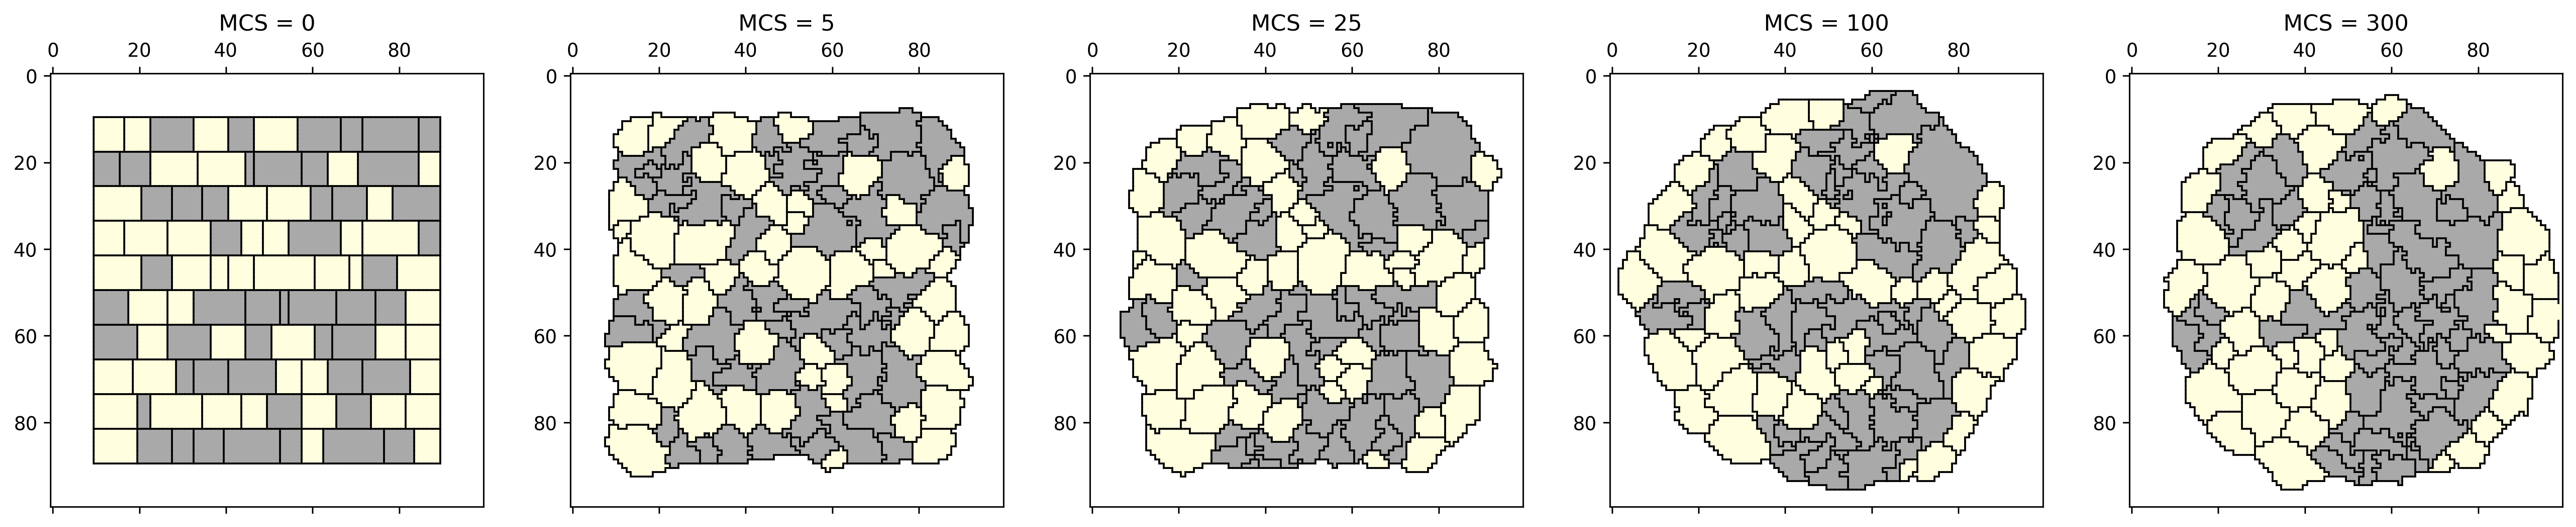

In [48]:
# Initial grid
grid = rectangular_grid(nx, n_rows, n_cols, width, height)

# Return the grid at this time steps (MCS)
return_metrics_at = [0, 5, 25, 100, 300]

# Simulation
grid, metrics = Cellular_Potts_model(grid, J, A, n_MCS, n_types, T, k, lam_vol, return_metrics_at)
grids = metrics['grids']

# Plotting
colors = ['darkgray', 'lightyellow']

fig, axes = plt.subplots(1, 5, figsize=(24,6), dpi=300)
sequence_plot(axes, return_metrics_at, grids, n_types, colors)
fig.savefig(f'{MEDIA_PATH}/cell_sorting.png', bbox_inches='tight')
fig.show()

### Animation

Simulating:   0%|          | 0/48000000 [00:00<?, ?step/s]

Rendering:   0%|          | 0/300 [00:00<?, ?frames/s]

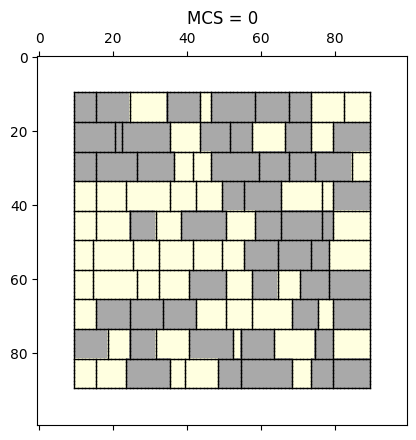

In [51]:
frames = 300
fps = 60
n_MCS = 300
assert n_MCS % frames == 0 # Ensure that the frames are evenly distributed

# Initial grid
grid = rectangular_grid(nx, n_rows, n_cols, width, height)

# Return the grid at this time steps (MCS)
return_metrics_at = np.arange(0, n_MCS, n_MCS//frames)

# Simulation
grid, metrics = Cellular_Potts_model(grid, J, A, n_MCS, n_types, T, k, lam_vol, return_metrics_at)
grids = metrics['grids']

anim = animate_grids(grids, return_metrics_at, fps, n_types, colors)
anim.save(f'{MEDIA_PATH}/animated_cellular_potts_paper_{n_MCS}MCS_{frames}_frames_{fps}_fps.gif', writer='ffmpeg')